<a href="https://colab.research.google.com/github/phylypo/TimeSeriesPrediction/blob/main/Time_Series_DL_TFT_N_BEATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of Time Series Forecasting from Statistical to Recent ML Approaches 

Topics for this notebook in bold:
- Introduction to TS
- Decompose (*Time_Series_FFT.ipynb*)
 - Gen Synthic
 - Decompose FFT
- Naive approaches
- Statistical (*Time_Series_ES_ARIMA.ipynb*)
 - Smoothing techniques
 - ARIMA
 - State Space (*Time_Series_StateSpace.ipynb*)
- ML (*Time_Series_ML-LR_XGBoost.ipynb*)
  - Linear Regression
  - Decision Tree (XGBoost)
- DL (*Time_Series_DL_LSTM_CNN.ipynb*)
 - LSTM, CNN + LSTM
 - TCN (*Time_Series_DL_TCN_LSTNet.ipynb*)
 - LSTNet
 - **TFT (*Time_Series_DL_TFT_N-BEATS.ipynb*)**
 - **N-BEATS**
- Commercial: (*Time_Series_Commercial.ipynb*)
 - Facebook Prophet
 - Amazon DeepAR

## Deep Learning

## TFT
Temporal Fusion Transformers (TFT)


"Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting"
Bryan Lim, Sercan O. Arık, Nicolas Loeffb, Tomas Pfister, Dec 2019 ([Paper](https://arxiv.org/abs/1912.09363.pdf))


![multi-horizon](https://storage.googleapis.com/groundai-web-prod/media/users/user_236644/project_402585/images/Schematic.png)


Compare to other models:
ARIMA, ETS, TRMF, DeepAR, DSSM, ConvTrans, Seq2Seq, MQRNN
- ETS (Error, Trend, Seasonal) method is an approach method for forecasting time series univariate. (https://otexts.com/fpp2/arima-ets.html)
- Deep State-Space Models (DSSM) [6] adopt a similar approach, utilizing LSTMs to generate parameters of a predefined linear state-space model with predictive distributions produced via Kalman filtering – with extensions for multivariate time series data in [21].
- Deep AR [9] which uses stacked LSTM layers to generate parameters of one-step-ahead Gaussian predictive distributions
- The Multi-horizon Quantile Recurrent Forecaster (MQRNN) [10] uses LSTM or convolutional encoders to generate context vectors which are fed into multi-layer perceptrons (MLPs) for each horizon.


In [11] a multi-modal attention mechanism is used with LSTM encoders to construct context vectors for a bi-directional LSTM decoder. Despite performing better than LSTM-based iterative methods, interpretability remains challenging for such standard direct methods.
(C. Fan, et al., Multi-horizon time series forecasting with temporal attention learning, 2019.)

By interpreting attention patterns, TFT can provide insightful explanations about temporal dynamics, and do so while maintaining state-ofthe-art performance on a variety of datasets.

![data](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/b941cb83f4aad597bf7ca72613d130c714d65d54/7-Table1-1.png)

Time Series Interpretability with Attention: 
- Attention mechanisms are used in translation [17], image classification [22] or tabular learning [23]
to identify salient portions of input for each instance using the magnitude of attention weights. 
- Recently, they have been adapted for time series with interpretability motivations [7, 12, 24], using LSTM-based [25] and transformer-based [12] architectures. However, this was done without considering the importance
of static covariates (as the above methods blend variables at each input). 
- TFT alleviates this by using separate encoder-decoder attention for static features at each time step on top of the self-attention to determine the contribution time-varying inputs.

Ref:
- https://arxiv.org/abs/1912.09363.pdf
- https://github.com/google-research/google-research/tree/master/tft
- https://github.com/louisyuzhe/deeplearning_forecast
- https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

## TFT Code

For this tutorial, we will use the Stallion dataset from Kaggle describing sales of various beverages. Our task is to make a six-month forecast of the sold volume by stock keeping units (SKU), that is products, sold by an agency, that is a store. There are about 21 000 monthly historic sales records. In addition to historic sales we have information about the sales price, the location of the agency, special days such as holidays, and volume sold in the entire industry.

### Install libraries

In [1]:
!pip install pytorch_lightning

In [2]:
!pip install pytorch_forecasting

In [3]:
!pip list | grep torch
!pip list | grep pytorch

pytorch-forecasting           0.8.4         
pytorch-lightning             1.2.7         
torch                         1.8.1+cu101   
torchmetrics                  0.2.0         
torchsummary                  1.5.1         
torchtext                     0.9.1         
torchvision                   0.9.1+cu101   
pytorch-forecasting           0.8.4         
pytorch-lightning             1.2.7         


In [4]:
USING_LOCAL_PF = True
if USING_LOCAL_PF:
    !git clone https://github.com/ethan-jiang-1/pytorch-forecasting.git pf
    import os
    os.chdir("/content/pf")
    !ls -l

fatal: destination path 'pf' already exists and is not an empty directory.
total 272
-rw-r--r-- 1 root root  11482 Apr  9 03:05 CHANGELOG.md
-rw-r--r-- 1 root root    121 Apr  9 03:05 codecov.yml
drwxr-xr-x 3 root root   4096 Apr  9 03:05 docs
drwxr-xr-x 3 root root   4096 Apr  9 03:05 examples
-rw-r--r-- 1 root root   1068 Apr  9 03:05 LICENSE
-rw-r--r-- 1 root root 217838 Apr  9 03:05 poetry.lock
-rw-r--r-- 1 root root   2551 Apr  9 03:05 pyproject.toml
-rw-r--r-- 1 root root    330 Apr  9 03:05 pytest.ini
drwxr-xr-x 4 root root   4096 Apr  9 03:05 pytorch_forecasting
-rwxr-xr-x 1 root root   5356 Apr  9 03:05 README.md
-rw-r--r-- 1 root root   1437 Apr  9 03:05 setup.cfg
drwxr-xr-x 4 root root   4096 Apr  9 03:05 tests


In [5]:
import pytorch_forecasting
print("pytorch_forecasting.__version__", pytorch_forecasting.__version__)
if pytorch_forecasting.__version__ == "0.0.0":
    print("using local version of pytorch_forecasting")

0.0.0


In [6]:
#https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import copy
import inspect
import os

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def inspect_instance(instance, mark):
    print("instance {}".format(mark), type(instance))
    print(instance.__class__.__name__)
    for kls in inspect.getmro(instance.__class__):
        print(" ", kls)

### Loading data

In [9]:
from pytorch_forecasting.data.examples import get_stallion_data

In [10]:
# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]

def get_src_data():
    data = get_stallion_data()
    # add time index
    data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
    data["time_idx"] -= data["time_idx"].min()

    # add additional features
    data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
    data["log_volume"] = np.log(data.volume + 1e-8)
    data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
    data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

    data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
    return data

df_data = get_src_data()
print(type(df_data))

<class 'pandas.core.frame.DataFrame'>


In [11]:
df_data.describe()

,volume,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
std,2711.496882,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698
min,0.000000,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375


In [12]:
df_data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,48151,132110,-,-,new_year,-,-,-,-,-,-,-,-,-,8.532566,0,0,1,3.956461,2613.377501,103.805460
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,32769,96761,-,-,new_year,-,-,-,-,-,-,-,-,-,13.000635,5,0,1,-18.420681,1361.511918,0.549900
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,1219986,218902,-,-,new_year,-,-,-,-,-,-,-,-,-,5.792496,9,0,1,6.700634,1225.306376,2041.909586
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,135561,100461,-,-,new_year,-,-,-,-,-,-,-,-,-,7.940950,14,0,1,5.757134,2613.377501,125.690220
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,3044268,182944,-,-,new_year,-,-,-,-,-,-,-,-,-,8.981168,22,0,1,6.042417,1179.728165,1638.463500


In [13]:
df_data.tail()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
6765,Agency_08,SKU_03,9.8136,2017-12-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,71662,123610,-,-,-,christmas,-,-,-,-,-,-,-,-,14.717926,336,59,12,2.283769,2304.827516,76.037400
6764,Agency_60,SKU_05,2235.3495,2017-12-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,2180611,211936,-,-,-,christmas,-,-,-,-,-,-,-,-,19.503372,188,59,12,7.712153,1530.930920,3311.367493
6763,Agency_19,SKU_05,87.5430,2017-12-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,48146,122042,-,-,-,christmas,-,-,-,-,-,-,-,-,18.655677,162,59,12,4.472130,1530.930920,56.557950
6771,Agency_60,SKU_03,325.8792,2017-12-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,2180611,211936,-,-,-,christmas,-,-,-,-,-,-,-,-,15.257220,187,59,12,5.786527,2304.827516,3311.367493
6650,Agency_56,SKU_01,3283.8480,2017-12-01,618073219,919709619,21.709841,1729.148426,1223.228147,505.920279,1901290,206553,-,-,-,christmas,-,-,-,-,-,-,-,-,29.258349,71,59,12,8.096771,2716.823019,3304.106100


In [14]:
df_data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,53598,95032,-,-,new_year,-,-,-,-,-,-,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,28329,93614,-,-,new_year,-,-,-,-,-,-,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,32183,128574,-,-,-,-,-,independence_day,-,-,-,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,1729177,111048,-,-,-,-,-,-,-,-,-,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,147910,123013,-,-,-,-,-,-,-,-,-,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,3044268,182944,-,-,-,-,-,-,-,-,-,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,135561,100461,-,-,-,-,-,-,-,-,-,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,1739969,210213,easter_day,good_friday,-,-,-,-,-,-,-,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,1868030,175785,-,-,-,-,-,-,-,-,-,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,26635,130092,easter_day,good_friday,-,-,-,-,-,-,-,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


### Training

#### dataset

In [15]:
MAX_PREDICTION_LENGTH = 6
MAX_ENCODER_LENGTH = 24

training_cutoff = df_data["time_idx"].max() - MAX_PREDICTION_LENGTH

training_dataset = TimeSeriesDataSet(
    df_data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],

    min_encoder_length=MAX_ENCODER_LENGTH // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=MAX_ENCODER_LENGTH,
    min_prediction_length=1,
    max_prediction_length=MAX_PREDICTION_LENGTH,

    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],

    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable

    time_varying_known_categoricals=["special_days", "month"],    
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",],
    
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], 
        # coerce_positive=1.0 --ethan
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation_dataset = TimeSeriesDataSet.from_dataset(training_dataset, 
                                                    df_data, 
                                                    predict=True, 
                                                    stop_randomization=True) 
                                                    # min_prediction_idx=training_cutoff+1)


#### dataloaders (train/val)

In [16]:
# create dataloaders for model
BATCH_SIZE = 128  # set this between 32 to 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=BATCH_SIZE * 10, num_workers=0)
print(type(train_dataloader))
print(type(val_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [17]:
def inspect_dataloader(dataloader, name):
    count = 0
    examples = 0
    print("inspect_dataloader", name)
    for x0, x1 in iter(dataloader):
        if count == 0:
            print("iterate dataloader will yield two content: x0 and x1")
            print("x0", type(x0), x0.keys())
            print("x1", type(x1), len(x1), type(x1[0]), x1[0].shape, type(x1[1]))
        count += 1
        examples +=  x1[0].shape[0]
    print("total batches:", count)
    print("total examples:", examples)


In [18]:
inspect_dataloader(train_dataloader, "train_dataloader")

inspect_dataloader train_dataloader
iterate dataloader will yield two content: x0 and x1
x0 <class 'dict'> dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])
x1 <class 'tuple'> 2 <class 'torch.Tensor'> torch.Size([128, 6]) <class 'NoneType'>
total batches: 161
total examples: 20608


In [19]:
inspect_dataloader(val_dataloader, "val_dataloader")

inspect_dataloader val_dataloader
iterate dataloader will yield two content: x0 and x1
x0 <class 'dict'> dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])
x1 <class 'tuple'> 2 <class 'torch.Tensor'> torch.Size([350, 6]) <class 'NoneType'>
total batches: 1
total examples: 350


### baseline

In [20]:
def exec_baseline():
    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    #actuals = torch.cat([y for x, y in iter(val_dataloader)])
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]) #ethan
    baseline_predictions = Baseline().predict(val_dataloader)
    baseline_ap_mean = (actuals - baseline_predictions).abs().mean().item()
    print("baseline a-p.mean", baseline_ap_mean)
    return 

baseline_ap_mean = exec_baseline()

baseline a-p.mean 293.0088195800781


#### trainer

In [21]:
#resume_from_checkpoint = 'some/path/to/my_checkpoint.ckpt'
resume_from_checkpoint = None

In [22]:
import os
# configure network and trainer
pl.seed_everything(42)
#os.makedirs("./logs", exist_ok=True)

trainer = pl.Trainer(gpus=1,  #ethan    #gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    min_epochs=2,
    max_epochs=60, #40, #ethan
    #default_root_dir=".",
    #weights_save_path=".",
    #profiler="advanced",
    resume_from_checkpoint=resume_from_checkpoint,
)
print("trainer", type(trainer))

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


trainer <class 'pytorch_lightning.trainer.trainer.Trainer'>


In [23]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 29.7k


In [24]:
inspect_instance(tft, "tft")

instance tft <class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>
TemporalFusionTransformer
  <class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>
  <class 'pytorch_forecasting.models.base_model.BaseModelWithCovariates'>
  <class 'pytorch_forecasting.models.base_model.BaseModel'>
  <class 'pytorch_lightning.core.lightning.LightningModule'>
  <class 'abc.ABC'>
  <class 'pytorch_lightning.utilities.device_dtype_mixin.DeviceDtypeModuleMixin'>
  <class 'pytorch_lightning.core.grads.GradInformation'>
  <class 'pytorch_lightning.core.saving.ModelIO'>
  <class 'pytorch_lightning.core.hooks.ModelHooks'>
  <class 'pytorch_lightning.core.hooks.DataHooks'>
  <class 'pytorch_lightning.core.hooks.CheckpointHooks'>
  <class 'torch.nn.modules.module.Module'>
  <class 'object'>


#### Training

In [25]:
def find_optimal_lr():
    global tft, train_dataloader, val_dataloader
    # find optimal learning rate
    res = trainer.tuner.lr_find(
        tft,
        train_dataloader=train_dataloader,
        val_dataloaders=val_dataloader,
        max_lr=10.0,
        min_lr=1e-6,
    )
    fig = res.plot(show=True, suggest=True)
    fig.show()
    print(f"suggested learning rate: {res.suggestion()}")
    return res.suggestion()

In [26]:
def train_by_trainer():
    global tft, train_dataloader, val_dataloader
    # can be stopped at any point -- did at 24 epochs
    # fit network
    trainer.fit(
        tft,
        train_dataloader=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    return trainer.checkpoint_callback.best_model_path

In [27]:
def optimize_hyperparameters():
    # can cancel, but wait after clicking -- take time to cancel
    from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

    # create study
    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=30, #200,
        max_epochs=10,#50
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 128),
        hidden_continuous_size_range=(8, 128),
        attention_head_size_range=(1, 4),
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.3),
        trainer_kwargs=dict(limit_train_batches=30),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    )

    import pickle
    # save study results - also we can resume tuning at a later point in time
    with open("test_study.pkl", "wb") as fout:
        pickle.dump(study, fout)

    # show best hyperparameters
    #print(study.best_trial.params)
    print("study.best_trial.params")
    for key in study.best_trial.params.keys():
        print(" ", key, study.best_trial.params[key])
    return study.best_trial.params


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Restored states from the checkpoint file at /content/pf/lr_find_temp_model.ckpt


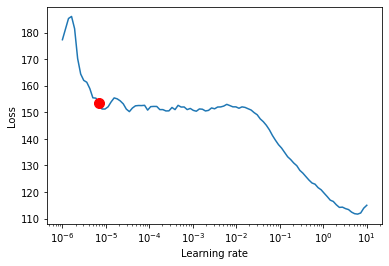

suggested learning rate: 6.918309709189363e-06


In [28]:
lr_suggested = find_optimal_lr()

In [ ]:
best_model_path = train_by_trainer()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning:

The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



In [ ]:
#best_trial_params = optimize_hyperparameters()

### Forecasting

#### pickup best_model

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
import os
#best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
if os.path.isfile(best_model_path):
    print("##Best model found", best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
inspect_instance(best_tft, "best_tft")

In [ ]:
del tft

#### Predictions


##### Predications - Normal

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
besttft_ap_mean = (actuals - predictions).abs().mean()
print("best_tft a-p.mean", besttft_ap_mean)

print("baseline_ap_mean {} vs besttft_ap_mean {}".format(baseline_ap_mean, besttft_ap_mean)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
for idx in range(0,3):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
for idx in range(3,6):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
for idx in range(6,9):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
for idx in range(9,12):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

##### Predications - Worst

In [ ]:
# worst performer
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses

In [ ]:
for idx in range(0,4):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

In [ ]:
for idx in range(4,8):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

In [ ]:
for idx in range(8, 12):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

In [ ]:
for idx in range(12, 16):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

##### Predictions - Best

In [ ]:
indices = mean_losses.argsort(descending=False)  # sort losses

In [ ]:
for idx in range(0,4):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

In [ ]:
for idx in range(4,8):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

In [ ]:
for idx in range(8,12):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

In [ ]:
for idx in range(12,16):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

#### Predication vs actual by variables

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)

In [ ]:
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

#### Predication on new data (last 24 months)

In [ ]:
#prediction on new data
# select last 24 months from data (MAX_ENCODER_LENGTH is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - MAX_ENCODER_LENGTH]

# select last known data point and create decoder data from it by repeating it and incrementing the month
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, MAX_PREDICTION_LENGTH + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw",return_x=True)

In [ ]:
for idx in range(0,2):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False, add_loss_to_title=True);

In [ ]:
for idx in range(2,4):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False, add_loss_to_title=True);

In [ ]:
for idx in range(4,6):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False, add_loss_to_title=True);

In [ ]:
for idx in range(6,8):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False, add_loss_to_title=True);

In [ ]:
for idx in range(8,10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False, add_loss_to_title=True);

#### Attention and Variables (importantance)

In [ ]:
# interpret model
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

## Plot Model

In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot

In [ ]:
def print_obj_key(obj, mark=None):
  if mark is not None:
      print(mark)
  for key in dict(obj):
    if not key.startswith("_"):
        print(key)

def get_feed_data():
  for x, y in iter(val_dataloader):
      if first:
        return x

In [ ]:
feed_data = get_feed_data()
resp_out = best_tft.__call__(feed_data)
print_obj_key(resp_out)
print(resp_out["prediction"].shape)

In [ ]:
#It may take a while, and output image maybe too large to load
make_dot(resp_out["prediction"]).render("network", format="png")

In [ ]:
import os
if os.path.isfile("network.png"):
    print("the network structure has been generated")
else:
    print("error")

## Summary

In deep learning, the sequence to sequence approach like RNN and LSTM does shows some promise but required a different architecture and finetuning.

TFT and N-BEATS are the lastest approaches that are the current state of the arts. They outperformed previous approaches and winner in the M4 competition.
